In [166]:
from statistics import LinearRegression

import numpy as np


def preprocess(dataset,initial_instance_count):
    if 'Verkaufspreis' in dataset.columns:
        # Deleting missing values, since there are only less than 1% of missing values
        dataset = dataset.dropna(subset=['Wohngebiet', 'Funktionalitaet', 'KuechenQualitaet', 'Elektrik',
                            'Verkaufstyp', 'Garagenflaeche', 'Garagenautos'])
        
        # Fill missing values with Linear Regression prediction in feature 'Strassenlaenge'
        model = LinearRegression()
        model.fit(np.array(dataset[dataset['Strassenlaenge'].notna()].Verkaufspreis).reshape(-1, 1), 
                dataset[dataset['Strassenlaenge'].notna()].Strassenlaenge)
        predicted_values = model.predict(np.array(dataset[dataset['Strassenlaenge'].isna()].Verkaufspreis).reshape(-1, 1))
        dataset.loc[dataset['Strassenlaenge'].isnull(), 'Strassenlaenge'] = predicted_values
    else:
        dataset['Strassenlaenge'] = dataset['Strassenlaenge'].fillna(dataset['Strassenlaenge'].mode()[0])

        features_fillna_mode = ['Wohngebiet', 'Funktionalitaet', 'KuechenQualitaet', 'Elektrik',
                            'Verkaufstyp', 'Garagenflaeche', 'Garagenautos']
        for feature in features_fillna_mode:
            dataset[feature] = dataset[feature].fillna(dataset[feature].mode()[0])


    # Fill missing values with mode
    features_fillna_mode = ['Funktionalitaet', 'KuechenQualitaet', 'Elektrik', 'Garagenbaujahr',
                            'Garageninnenausbau', 'Garagentyp']
    for feature in features_fillna_mode:
        dataset[feature] = dataset[feature].fillna(dataset[feature].mode()[0])


    # Fill missing values with NA
    features_fillna_nan = ['Kellerhoehe', 'Kellerzustand', 'Kellerbelichtung', 
                        'Kellerbereich1', 'Kellerbereich2', 'Kaminqualitaet',
                        'Zaunqualitaet']
    for feature in features_fillna_nan:
        dataset[feature] = dataset[feature].fillna('NA')


    # Fill missing values with 0.0
    features_fillna_0 = ['Kellerbereichgroesse1', 'Kellerbereichgroesse2', 'KellerbereichgroesseGes', 
                        'KellerbereichgroesseNAu', 'KellerVollbadezimmer', 'KellerHalbbadezimmer',
                        'Mauerwerkflaeche']
    for feature in features_fillna_0:
        dataset[feature] = dataset[feature].fillna(0.0)

    # Fill Mauerwerktyp with 'Kein'
    dataset['Mauerwerktyp'] = dataset['Mauerwerktyp'].fillna('Kein')


    # Deleting features 'Versorgung' because there are 2 missing values and others are 'EGWA'
    # Deleting features 'Kellerbereichgroesse2' because there are no good distribution of values 
    # Delete other features because they have too many null values
    dataset = dataset.drop(['Versorgung', 'Kellerbereichgroesse2', 'GeringequalitaetFlaeche',
                'Zufahrtsweg', 'Sondermerkmal', 'Poolqualitaet',
                'Garagenqualitaet', 'Garagenzustand'], axis=1)
    
    if 'Verkaufspreis' in dataset.columns:
        # Limit 'Grundstuecksgroesse' with 6000 m2
        dataset = dataset[dataset['Grundstuecksgroesse'] < 6000]

        # Limit 'Strassenlaenge' with 60 m
        dataset = dataset[dataset['Strassenlaenge'] <= 60]

        # Delete instance 714 because there Baujahr is bigger than Umbaujahr
        dataset = dataset[dataset['Umbaujahr'] >= dataset['Baujahr']]

        # Delete Garagenbaujahr bigger than 2023
        dataset = dataset[dataset['Garagenbaujahr'] < 2023]

    # Delete 'Bedingung2' because there are only 13 values which are not 'Norm'
    dataset = dataset.drop('Bedingung2', axis=1)

    # Merge values EbOA, EbOU, EbNA, EbNU into 'Hbf' and PosN, PosA into 'Pos' for 'Bedingung1' feature
    dataset['Bedingung1'] = dataset['Bedingung1'].replace(['EbOA', 'EbOU', 'EbNA', 'EbNU'], 'Hbf')
    dataset['Bedingung1'] = dataset['Bedingung1'].replace(['PosN', 'PosA'], 'Pos')

    # Delete features 'Grundstuecksform', 'Gelaendeneigun', 'Strassentyp', 'Dachmaterial' because of bad distribution of values
    dataset = dataset.drop(['Grundstuecksform', 'Gelaendeneigung', 'Strassentyp', 'Dachmeterial'], axis=1)
    
    final_instance_count = len(dataset)
    final_feature_count = len(dataset.columns)

    print(f'{initial_instance_count - final_instance_count} '
        f'({round((initial_instance_count - final_instance_count) / initial_instance_count * 100, 3)}%)'
        f' Exemplare wurden entfernt. \nAnzahle von Exemplare: {final_instance_count}'
        f'\nAnzahle von Merkmale: {final_feature_count}')
    
    return dataset


# Data Cleaning (Train)

In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression

df = pd.read_csv('train.csv', index_col='Id')

initial_instance_count = len(df)
initital_feature_count = len(df.columns)

print(f'Anzahle von Exemplare: {initial_instance_count}\nAnzahle von Merkmale: {initital_feature_count}')

Anzahle von Exemplare: 2000
Anzahle von Merkmale: 80


In [168]:

df = preprocess(df,initial_instance_count)

14 (0.7%) Exemplare wurden entfernt. 
Anzahle von Exemplare: 1986
Anzahle von Merkmale: 67


C:\Users\weidn\AppData\Local\Temp\ipykernel_18844\406425908.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[feature] = dataset[feature].fillna(dataset[feature].mode()[0])
C:\Users\weidn\AppData\Local\Temp\ipykernel_18844\406425908.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[feature] = dataset[feature].fillna('NA')
C:\Users\weidn\AppData\Local\Temp\ipykernel_18844\406425908.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [169]:
df.isna().sum().sort_values(ascending=False).head(5)

Wohngebiet                    0
GeschlosseneVerandaflaeche    0
Funktionalitaet               0
OberirdischeVollbadezimmer    0
OberirdischeHalbbadezimmer    0
dtype: int64

# Data Cleaning (Test)

In [170]:
df_test_id = pd.read_csv('test.csv')
df_test = df_test_id.drop('Id', axis=1)
initial_instance_count_test = len(df_test)
initital_feature_count_test = len(df_test.columns)

print(f'Anzahle von Exemplare: {initial_instance_count_test}\nAnzahle von Merkmale: {initital_feature_count_test}')

Anzahle von Exemplare: 919
Anzahle von Merkmale: 79


In [171]:
df_test = preprocess(df_test,initial_instance_count_test)

0 (0.0%) Exemplare wurden entfernt. 
Anzahle von Exemplare: 919
Anzahle von Merkmale: 66


In [172]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
numeric_columns = df_test.describe().columns
categorical_columns = df_test.columns.difference(numeric_columns)
for i in categorical_columns:
    df_test[i] = le.fit_transform(df_test[i])

sc_x = StandardScaler()
df_test[numeric_columns] = sc_x.fit_transform(df_test[numeric_columns])

# Training

In [173]:
y = df['Verkaufspreis']
X = df.drop('Verkaufspreis', axis=1)
print(X.shape, y.shape)

(1986, 66) (1986,)


In [174]:
# normalize
le = LabelEncoder()
numeric_columns = X.describe().columns
categorical_columns = X.columns.difference(numeric_columns)
for i in categorical_columns:
    X[i] = le.fit_transform(X[i])

sc_x = StandardScaler()
sc_y = StandardScaler()
X[numeric_columns] = sc_x.fit_transform(X[numeric_columns])
y = sc_y.fit_transform(np.array(y).reshape(-1, 1))
y = y.reshape(1,-1)[0]

In [175]:
from sklearn.model_selection import train_test_split


# df_encoded = pd.get_dummies(df)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [176]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

# We searched the best hyperparameters with RandomizedSearchCV
# forest = RandomForestRegressor(random_state=42, n_estimators=800,min_samples_split=2,min_samples_leaf=1,max_features='sqrt',max_depth=40,bootstrap=False )

model = SVR()

# Train the model
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

R^2 Score: 0.932299753358784
Mean Squared Error: 0.051505976022884765


In [177]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

def predict_plot(model, X_test, y_test):

    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    cv_score = cross_val_score(model, X_test, y_test, cv=6)
    cv_score_train = cross_val_score(model, X_train, y_train, cv=6)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Print accuracy score on the test data
    print(f'Accuracy on test data: {model.score(X_test, y_test):.4f}')

    # Print the evaluation metrics
    print(f'Cross-Validation Score : {cv_score.mean():.4f}')
    print(f'Cross val socer train: {cv_score_train.mean():.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')

    
    # Visualize predicted vs. actual prices in a scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.title('Predicted vs. Actual Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.show()

    return y_pred

Accuracy on test data: 0.9323
Cross-Validation Score : 0.8809
Cross val socer train: 0.9013
Mean Squared Error (MSE): 0.0515
Root Mean Squared Error (RMSE): 0.2269
Mean Absolute Error (MAE): 0.1632
Mean Absolute Percentage Error (MAPE): 2.2606%


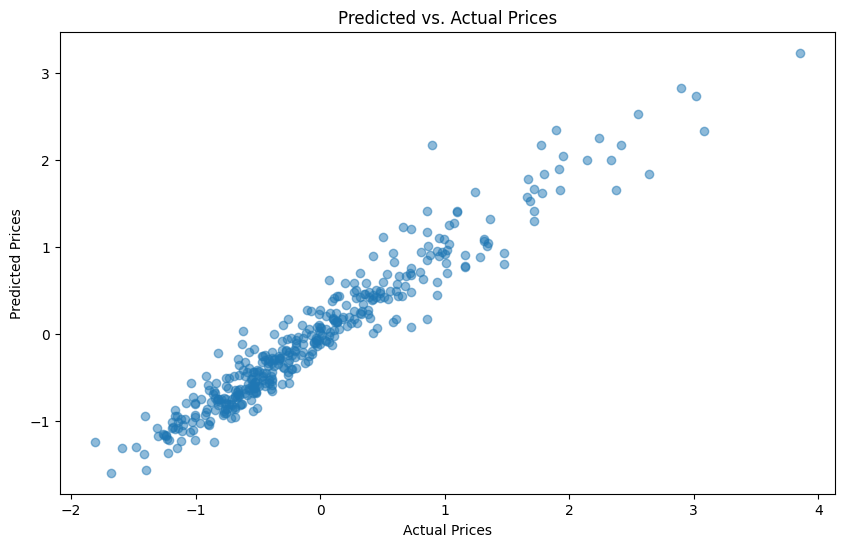

In [178]:
v_pred = predict_plot(model, X_test, y_test)

# Evaluation

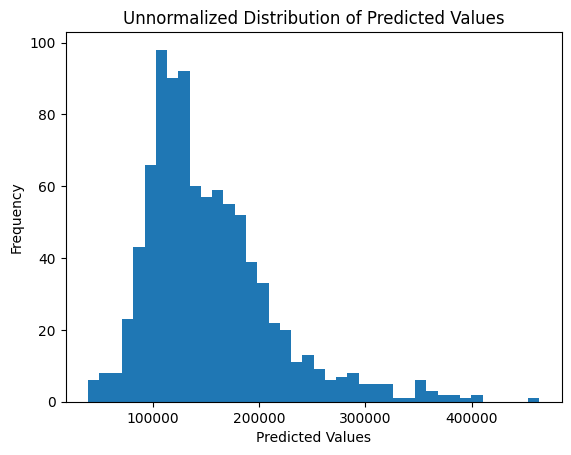

In [184]:
predicted = model.predict(df_test)

unnormalized = sc_y.inverse_transform(predicted.reshape(-1, 1))

prediction_avg = pd.read_csv("prediction_avg.csv")

prediction_avg["Verkaufspreis"] = unnormalized

prediction_avg.to_csv('prediction_avg.csv', index=False)

import matplotlib.pyplot as plt

plt.hist(unnormalized, bins=40)
plt.title('Unnormalized Distribution of Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Frequency')
plt.show()


